In [4]:
!pip install catboost

   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.8/102.4 MB 6.7 MB/s eta 0:00:16
   - -------------------------------------- 2.6/102.4 MB 7.5 MB/s eta 0:00:14
   - -------------------------------------- 5.0/102.4 MB 9.1 MB/s eta 0:00:11
   -- ------------------------------------- 7.6/102.4 MB 9.8 MB/s eta 0:00:10
   --- ------------------------------------ 10.0/102.4 MB 10.2 MB/s eta 0:00:10
   ---- ----------------------------------- 11.8/102.4 MB 10.0 MB/s eta 0:00:10
   ----- ---------------------------------- 13.9/102.4 MB 9.9 MB/s eta 0:00:09
   ------ --------------------------------- 15.5/102.4 MB 9.6 MB/s eta 0:00:10
   ------ --------------------------------- 17.3/102.4 MB 9.6 MB/s eta 0:00:09
   ------- -------------------------------- 19.4/102.4 MB 9.6 MB/s eta 0:00:09
   -------- ------------------------------- 21.5/102.4 MB 9.6 MB/s eta 0:00:09
   --------- ------------------------------ 23.6/102.4 MB 9.6 

In [5]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path

In [6]:
current_dir = Path.cwd()

In [7]:
data_path = current_dir.parent.parent / 'Data_Processing' / 'merge' / 'df+dist+hol.csv'

In [9]:
df = pd.read_csv(data_path)

In [4]:
df.columns

Index(['city_address', 'day_precip', 'day_precipcover', 'day_snow',
       'day_windspeed', 'day_winddir', 'day_uvindex', 'hour_temp',
       'hour_humidity', 'hour_precip', 'hour_precipprob', 'hour_snow',
       'hour_windspeed', 'hour_winddir', 'hour_pressure', 'hour_visibility',
       'hour_cloudcover', 'hour_uvindex', 'datetime', 'Clear', 'Ice', 'Snow',
       'Overcast', 'Rain', 'Fog', 'Partially cloudy',
       'Freezing Drizzle/Freezing Rain', 'anomaly', 'alarms', 'date',
       'text_vector', 'tg_vector', 'sun', 'Engels2', 'Baltimore', 'Saki',
       'Belbek', 'Olenya', 'Mozdok', 'Savasleyka', 'hol_risk'],
      dtype='object')

In [5]:
df.rename(columns={'text_vector': 'isw_vector'}, inplace=True)

In [6]:
df['alarms'] = df['alarms'].apply(lambda x: 0 if x == 0 else 1)

In [7]:
df['alarms'].value_counts()

,count
alarms,
0,502391
1,105844


In [8]:
df.isnull().sum()

,0
city_address,0
day_precip,0
day_precipcover,0
day_snow,0
day_windspeed,0
day_winddir,0
day_uvindex,0
hour_temp,0
hour_humidity,0
hour_precip,0


In [9]:
df['isw_vector'] = df['isw_vector'].fillna(0)

In [10]:
df['datetime'] = pd.to_datetime(df['datetime'])

df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second

In [11]:
df = df.drop(columns=['datetime'])
df = df.drop(columns=['date'])
df = df.drop(columns=['anomaly'])
df = df.drop(columns=['city_address'])

In [ ]:
df_majority = df[df['alarms'] == 0]
df_minority = df[df['alarms'] == 1]

df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)


df_balanced = pd.concat([df_majority, df_minority_upsampled])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_balanced['alarms'].value_counts()

,count
alarms,
1,502391
0,502391


***MODEL***

In [ ]:
X = df_balanced.drop('alarms', axis=1)
y = df_balanced['alarms']

tscv = TimeSeriesSplit(n_splits=4)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [ ]:
model = CatBoostClassifier(verbose=0, random_state=42)

# Hyperparameters for RandomizedSearchCV
params = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'iterations': [100, 300, 500],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128],
    'random_strength': [1, 2, 5, 10]
}

# RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1
)


In [ ]:
search.fit(X_train, y_train)

# The best parameters
print("Best Params:", search.best_params_)

# The best model
best_model = search.best_estimator_

# Rating
y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params: {'random_strength': 2, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'iterations': 300, 'depth': 10, 'border_count': 64}
Classification Report:
               precision    recall  f1-score   support

           0     0.9263    0.8429    0.8827    100407
           1     0.8561    0.9331    0.8929    100549

    accuracy                         0.8880    200956
   macro avg     0.8912    0.8880    0.8878    200956
weighted avg     0.8912    0.8880    0.8878    200956

Confusion Matrix:
 [[84635 15772]
 [ 6730 93819]]


**To increase efficiency, it was decided to increase the number of iterations to 700.**

**Final hyperparameters:**
{'random_strength': 2, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'iterations': **700**, 'depth': 10, 'border_count': 64}

***Final model:***

In [ ]:
model = CatBoostClassifier(iterations=700, depth=10, random_strength=2,
                           learning_rate=0.2, l2_leaf_reg=1, random_state=42,
                           border_count=64, verbose=0)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0     0.9677    0.8833    0.9236    100407
           1     0.8928    0.9706    0.9301    100549

    accuracy                         0.9270    200956
   macro avg     0.9303    0.9269    0.9268    200956
weighted avg     0.9302    0.9270    0.9268    200956

Confusion Matrix:
 [[88687 11720]
 [ 2958 97591]]


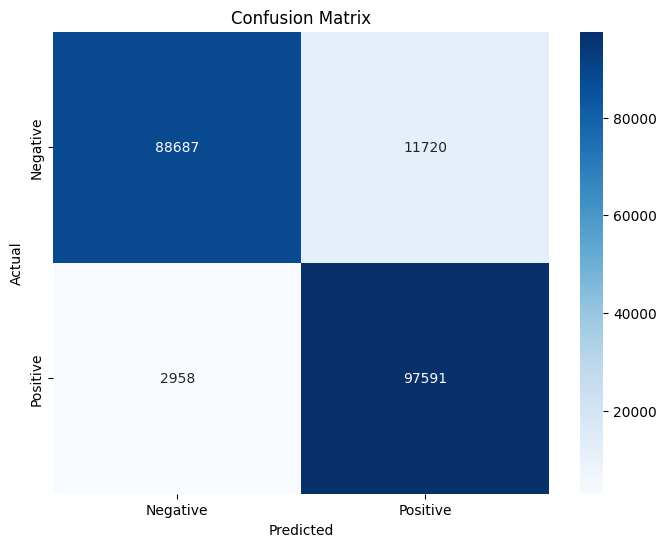

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

---
**Graph to see if the model is overfitting**

**Overfitting is generally up to 2%, which is normal**

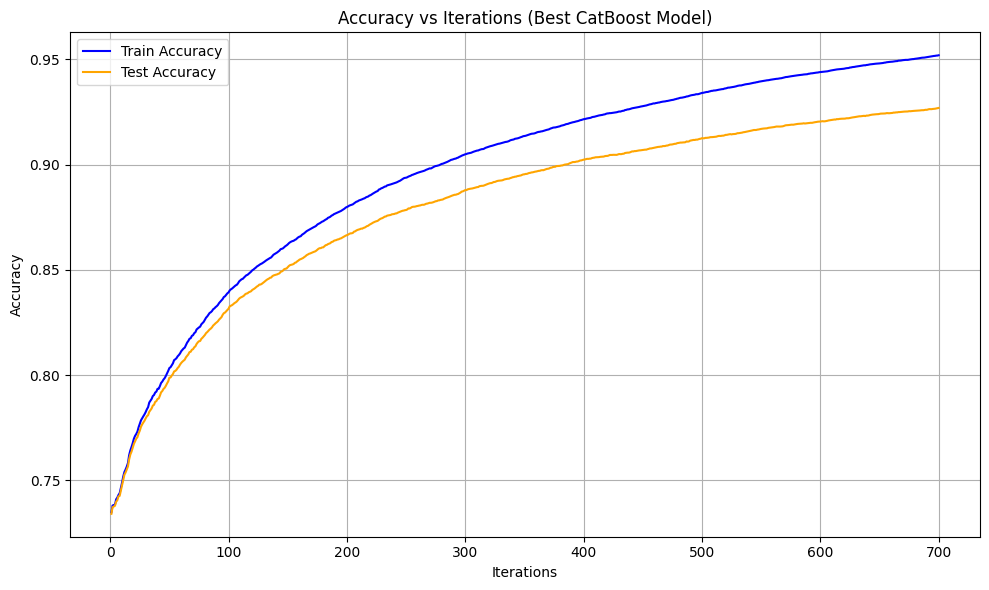

In [ ]:
best_params_ = {'random_strength': 2, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'iterations': 700, 'depth': 10, 'border_count': 64}

best_model = CatBoostClassifier(
    **best_params_,
    eval_metric='Accuracy',
    use_best_model=False,
    verbose=0,
    random_state=42
)

best_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False,
    metric_period=1
)

train_accuracy = best_model.eval_metrics(Pool(X_train, y_train), ['Accuracy'])['Accuracy']
test_accuracy = best_model.eval_metrics(Pool(X_test, y_test), ['Accuracy'])['Accuracy']

plt.figure(figsize=(10, 6))
plt.plot(range(1, 701), train_accuracy, label='Train Accuracy', color='blue')
plt.plot(range(1, 701), test_accuracy, label='Test Accuracy', color='orange')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Iterations (Best CatBoost Model)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

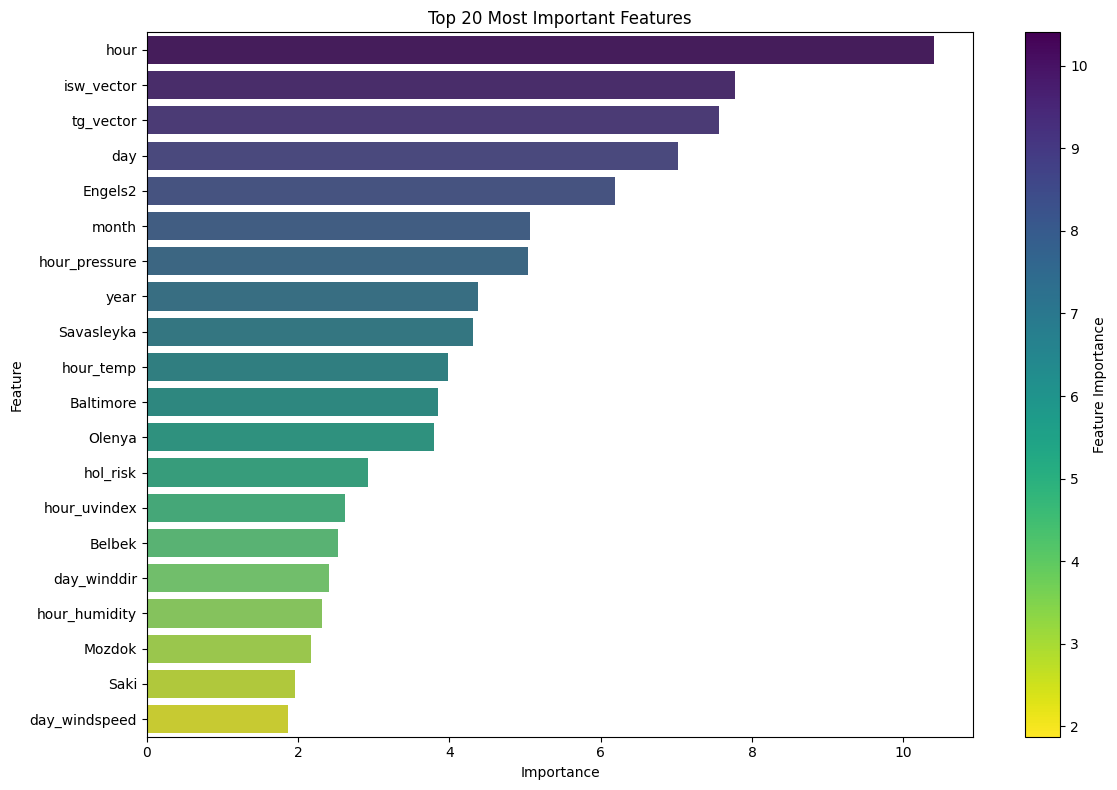

In [ ]:
feature_cols = X_train.columns.tolist()

importances = model.feature_importances_
features = pd.DataFrame({"Feature": feature_cols, "Importance": importances})

sorted_features = features.sort_values(by="Importance", ascending=False).head(20)

plt.figure(figsize=(12, 8))

norm = plt.Normalize(sorted_features['Importance'].min(), sorted_features['Importance'].max())
sm = plt.cm.ScalarMappable(cmap="viridis_r", norm=norm)
sm.set_array([])

ax = sns.barplot(
    x="Importance",
    y="Feature",
    data=sorted_features,
    hue="Feature",
    palette=sns.color_palette("viridis", n_colors=len(sorted_features)),
    dodge=False,
    legend=False
)

cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Feature Importance')

plt.title("Top 20 Most Important Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

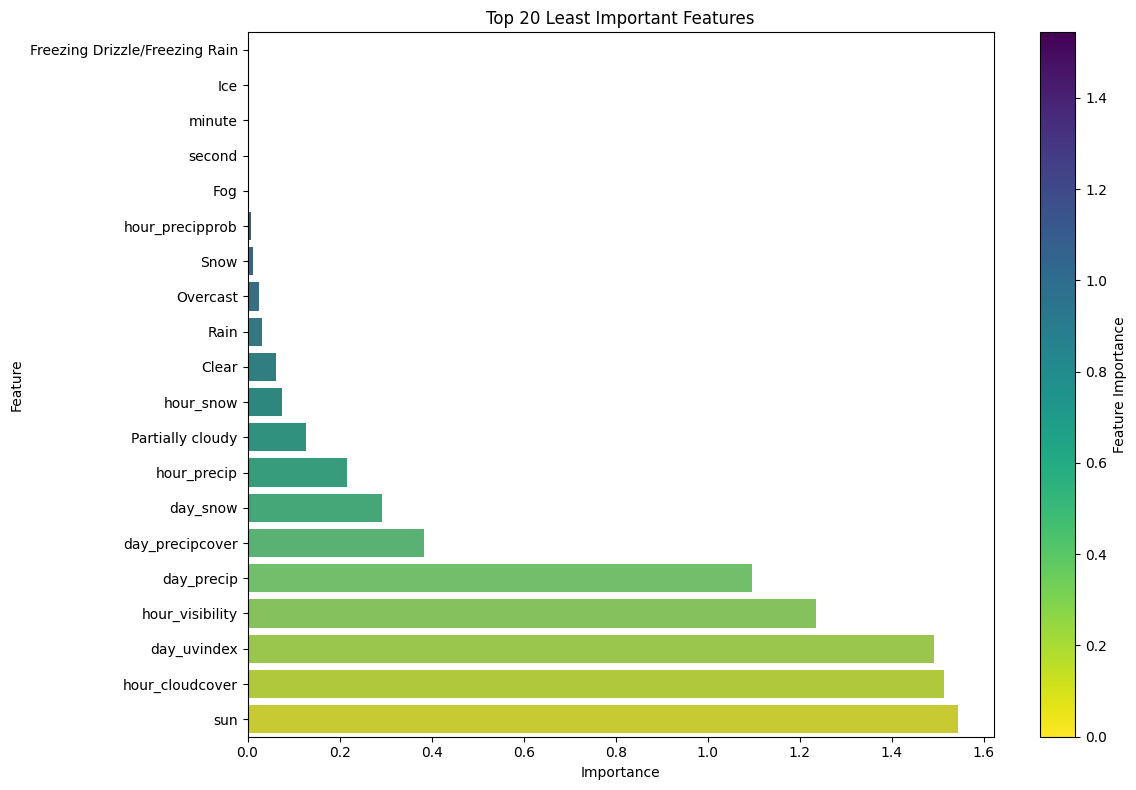

In [ ]:
importances = model.feature_importances_
features = pd.DataFrame({"Feature": feature_cols, "Importance": importances})

sorted_features = features.sort_values(by="Importance", ascending=True).head(20)

plt.figure(figsize=(12, 8))

norm = plt.Normalize(sorted_features['Importance'].min(), sorted_features['Importance'].max())
sm = plt.cm.ScalarMappable(cmap="viridis_r", norm=norm)
sm.set_array([])

ax = sns.barplot(
    x="Importance",
    y="Feature",
    data=sorted_features,
    hue="Feature",
    palette=sns.color_palette("viridis", n_colors=len(sorted_features)),
    dodge=False,
    legend=False
)

cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Feature Importance')

plt.title("Top 20 Least Important Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

---
***Save model***

In [ ]:
command_id = 1
model_name = "catboost_classifier"
version = "v1"

file_name = f"{command_id}__{model_name}__{version}.pkl"

model.save_model(file_name)